#Import

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime  
import csv
import os
from os import listdir
import json
import csv
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
np.random.seed(2018)

from google.colab import drive
drive.mount('/content/gdrive')
drive = '/content/gdrive/My Drive/PaperGiugno/'
path_db = drive + 'db_blackblaze'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Mounted at /content/gdrive


#Functions

In [2]:
def computeDay(group):
  group = group.sort_values('date')    #ordino in base ai giorni... dal più recente al meno
  group['DayToFailure'] = list(range(group.shape[0]-1, -1,-1 ))
  return group

def mean_absolute_percentage_error(y_true, y_pred): 
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
def mean_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean((y_true - y_pred) / y_true) * 100
  

def RegressionkfoldCVrepeated(model, X, y, nsplits, nrepeats, randomstate):
  
  kf = RepeatedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=randomstate)
  it=0
  msecross=[]
  maecross=[]
  mpecross=[]
  mapecross=[]
  r2cross=[]

  mse=[]
  mae=[]
  mpe=[]
  mape=[]
  r2=[]
  
  
  for train_index, test_index in kf.split(X):
    model = model.fit(X.values[train_index], y.values[train_index] )
    pred=model.predict(X.values[test_index])
    
    mse.append(mean_squared_error( y.values[test_index],pred))
    mae.append(mean_absolute_error( y.values[test_index],pred))
    mpe.append(mean_percentage_error( y.values[test_index],pred))
    mape.append(mean_absolute_percentage_error( y.values[test_index],pred))
    r2.append(r2_score( y.values[test_index],pred))
  
    it=it+1
    
    if (it % nsplits)==0:
      msecross.append(np.array(mse).mean())
      maecross.append(np.array(mae).mean())
      mpecross.append(np.array(mpe).mean())
      mapecross.append(np.array(mape).mean())
      r2cross.append(np.array(r2).mean())
      mse=[]
      mae=[]
      mpe=[]
      mape=[]
      r2=[]
    
  return  msecross, maecross, mpecross, mapecross, r2cross

#Pre-processing

In [3]:
df= pd.read_csv(path_db+ '/'+'BalckDaUsare.csv',sep=';')
df.date = pd.to_datetime(df.date, format='%Y-%m-%d').dt.date
df = df.drop(['CurrentPendingSectorCount','ReallocatedSectorsCount'], axis=1)
df.shape

df.columns

Index(['date', 'serial_number', 'ReportedUncorrectableErrors', 'HighFlyWrites',
       'TemperatureCelsius', 'RawCurrentPendingSectorCount',
       'RawReadErrorRate', 'SpinUpTime', 'RawReallocatedSectorsCount',
       'SeekErrorRate', 'PowerOnHours', 'Label'],
      dtype='object')

In [4]:
scaler = MinMaxScaler(feature_range = (-1,1))
df[['ReportedUncorrectableErrors', 'HighFlyWrites', 'TemperatureCelsius', 
    'RawCurrentPendingSectorCount','RawReadErrorRate', 'SpinUpTime', 
    'RawReallocatedSectorsCount', 'SeekErrorRate', 'PowerOnHours']] = scaler.fit_transform(df[['ReportedUncorrectableErrors', 
                                                                                               'HighFlyWrites', 'TemperatureCelsius', 
                                                                                               'RawCurrentPendingSectorCount',
                                                                                               'RawReadErrorRate', 'SpinUpTime', 
                                                                                               'RawReallocatedSectorsCount', 
                                                                                               'SeekErrorRate', 'PowerOnHours']])

df.columns


Index(['date', 'serial_number', 'ReportedUncorrectableErrors', 'HighFlyWrites',
       'TemperatureCelsius', 'RawCurrentPendingSectorCount',
       'RawReadErrorRate', 'SpinUpTime', 'RawReallocatedSectorsCount',
       'SeekErrorRate', 'PowerOnHours', 'Label'],
      dtype='object')

#Correlation

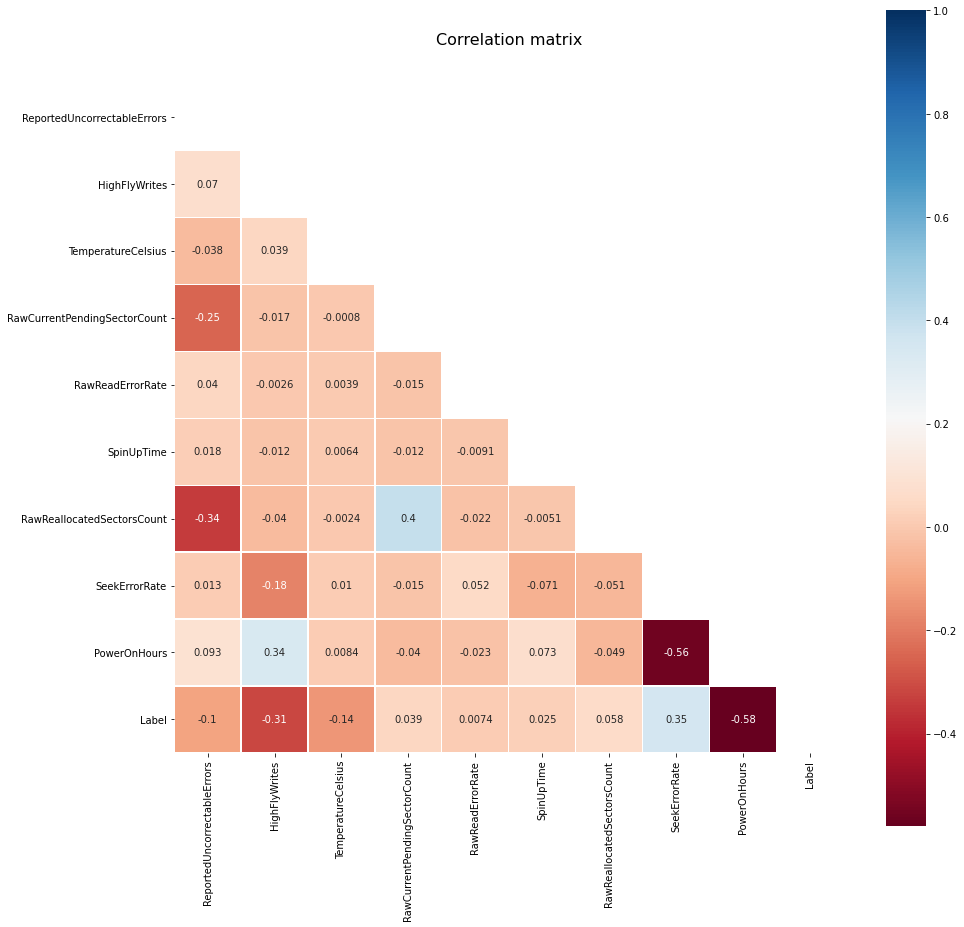

In [5]:
cr= df[['ReportedUncorrectableErrors', 'HighFlyWrites',
       'TemperatureCelsius', 'RawCurrentPendingSectorCount',
       'RawReadErrorRate', 'SpinUpTime', 'RawReallocatedSectorsCount',
       'SeekErrorRate', 'PowerOnHours', 'Label']].corr()


#### ----  HEATMAP per correlazione

colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
plt.title('Correlation matrix', y=1.05, size=16)

mask = np.zeros_like(cr)
mask[np.triu_indices_from(mask)] = True

heatm = sns.heatmap(cr, mask = mask, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#Day to failure

In [6]:
dfHour = df.groupby(['serial_number', 'Label']).apply(computeDay)
dfHour = dfHour[dfHour.DayToFailure <= 45]

#Correlation on bad devices 

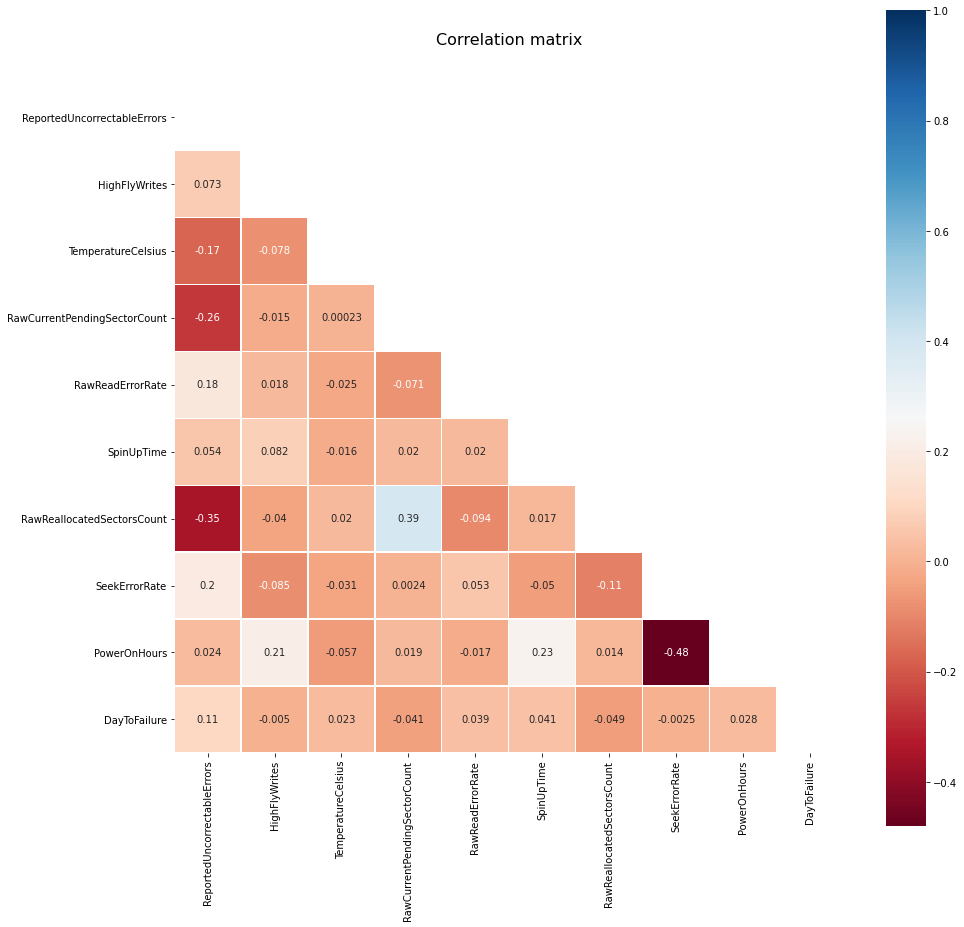

In [7]:
dfHourBad = dfHour[dfHour.Label==1]     #prendo quelli che falliscono
dfHourBad.columns

cr2= dfHourBad[['ReportedUncorrectableErrors', 'HighFlyWrites',
       'TemperatureCelsius', 'RawCurrentPendingSectorCount',
       'RawReadErrorRate', 'SpinUpTime', 'RawReallocatedSectorsCount',
       'SeekErrorRate', 'PowerOnHours', 'DayToFailure']].corr()

colormap = plt.cm.RdBu
plt.figure(figsize=(15,15))
plt.title('Correlation matrix', y=1.05, size=16)

mask = np.zeros_like(cr2)
mask[np.triu_indices_from(mask)] = True

heatm = sns.heatmap(cr2, mask = mask, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#Albero

In [8]:
dfHourBad = dfHourBad[dfHourBad.DayToFailure <= 45]   #prendo solo gli ultimi 45 campioni

In [9]:
import warnings
warnings.filterwarnings("ignore")

selectedmse = []
selectedmae = []
selectedmpe = []
selectedmape =[]

selectedr2 = []
nfogliemse = []
nfogliemae = []
nfogliempe = []
nfogliemape = []
nfoglier2 = []

listaDaEsplorare = [ 'ReportedUncorrectableErrors', 'HighFlyWrites', 'TemperatureCelsius', 'RawCurrentPendingSectorCount',
                    'RawReadErrorRate', 'SpinUpTime', 'RawReallocatedSectorsCount', 'SeekErrorRate', 
                    'PowerOnHours']

for feature in listaDaEsplorare:
  print('Working on feature: ', feature)
  mse_vet=[]
  mae_vet=[]
  mpe_vet=[]
  mape_vet= []
  r2_vet= []
  
  datafortree = pd.DataFrame(dfHourBad['DayToFailure'])
  y = dfHourBad[feature]
  
  list_foglie = list(range(30,dfHourBad.shape[0], 30 ))
  
  for x in list_foglie: 
    print('     --> min_samples_leaf: ', x)
    clf = tree.DecisionTreeRegressor(criterion='mse', min_samples_leaf = x)
    msecross, maecross, mpecross, mapecross, r2cross = RegressionkfoldCVrepeated(clf, datafortree, y,
                                                                                 nsplits=10, nrepeats=1, 
                                                                                 randomstate=8241)    
    mse_vet.append(np.array(msecross).mean()) 
    mae_vet.append(np.array(maecross).mean())
    mpe_vet.append(np.array(mpecross).mean())
    mape_vet.append(np.array(mapecross).mean())
    r2_vet.append(np.array(r2cross).mean())
    
    
  min_mse = min(mse_vet)
  min_mae = min(mae_vet)
  min_mpe = min(mpe_vet)
  min_mape = min(mape_vet)
  max_r2  = max(r2_vet)
  
  leaf_mse = list_foglie[mse_vet.index(min_mse)]
  leaf_mae = list_foglie[mae_vet.index(min_mae)]
  leaf_mpe = list_foglie[mpe_vet.index(min_mpe)]
  leaf_mape = list_foglie[mape_vet.index(min_mape)]
  leaf_r2 = list_foglie[r2_vet.index(max_r2)]
  
  selectedmse.append(min_mse)
  selectedmae.append(min_mae)
  selectedmpe.append(min_mpe)
  selectedmape.append(min_mape)
  selectedr2.append(max_r2)
  
  nfogliemse.append(leaf_mse)
  nfogliemae.append(leaf_mae)
  nfogliempe.append(leaf_mpe)
  nfogliemape.append(leaf_mape)
  nfoglier2.append(leaf_r2)  

Working on feature:  ReportedUncorrectableErrors
     --> min_samples_leaf:  30
     --> min_samples_leaf:  60
     --> min_samples_leaf:  90
     --> min_samples_leaf:  120
     --> min_samples_leaf:  150
     --> min_samples_leaf:  180
     --> min_samples_leaf:  210
     --> min_samples_leaf:  240
     --> min_samples_leaf:  270
     --> min_samples_leaf:  300
     --> min_samples_leaf:  330
     --> min_samples_leaf:  360
     --> min_samples_leaf:  390
     --> min_samples_leaf:  420
     --> min_samples_leaf:  450
     --> min_samples_leaf:  480
     --> min_samples_leaf:  510
     --> min_samples_leaf:  540
     --> min_samples_leaf:  570
     --> min_samples_leaf:  600
     --> min_samples_leaf:  630
     --> min_samples_leaf:  660
     --> min_samples_leaf:  690
     --> min_samples_leaf:  720
     --> min_samples_leaf:  750
     --> min_samples_leaf:  780
     --> min_samples_leaf:  810
     --> min_samples_leaf:  840
     --> min_samples_leaf:  870
     --> min_samples_leaf:

In [12]:
table = pd.DataFrame()
table['listaDaEsplorare']=  listaDaEsplorare
table['selectedmse']= selectedmse
table['selectedmae']= selectedmae
table['selectedmpe']= selectedmpe
table['selectedmape']= selectedmape
table['selectedr2']=selectedr2
table['nfogliemse']= nfogliemse
table['nfogliemae']= nfogliemae
table['nfogliempe']= nfogliempe
table['nfogliemape']= nfogliemape
table['nfoglier2']= nfoglier2

table

,listaDaEsplorare,selectedmse,selectedmae,selectedmpe,selectedmape,selectedr2,nfogliemse,nfogliemae,nfogliempe,nfogliemape,nfoglier2
0,ReportedUncorrectableErrors,0.041742,0.062103,6.150280,11.204603,0.008067,480,480,2130,150,480
1,HighFlyWrites,0.009187,0.048494,-1.258763,6.563681,-0.002365,3330,2760,30,3210,3330
2,TemperatureCelsius,0.144033,0.305154,inf,inf,-0.002206,3330,3330,30,30,3330
3,RawCurrentPendingSectorCount,0.001982,0.002894,0.149897,0.415636,-0.121744,750,3150,150,2280,3330
4,RawReadErrorRate,0.059985,0.185915,-inf,inf,0.001259,450,3330,30,30,450
5,SpinUpTime,0.277064,0.433728,67.244295,101.900782,-0.000400,3180,3060,3210,3060,3180
6,RawReallocatedSectorsCount,0.001297,0.004745,-0.012225,0.609556,-0.007600,1830,2280,3300,2280,3300
7,SeekErrorRate,0.064107,0.178347,46.353452,120.667415,-0.001131,3330,3330,570,3330,3330
8,PowerOnHours,0.180798,0.352790,34.927225,131.752329,-0.001514,3060,3060,1980,1380,3060


In [13]:
table.selectedmse.min()

0.001296837732523054

In [14]:
datafortree = pd.DataFrame(dfHourBad['DayToFailure'])
y = dfHourBad['RawReallocatedSectorsCount']
clf = tree.DecisionTreeRegressor(criterion='mse', min_samples_leaf = 1830 	)
clf.fit(datafortree, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1830, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

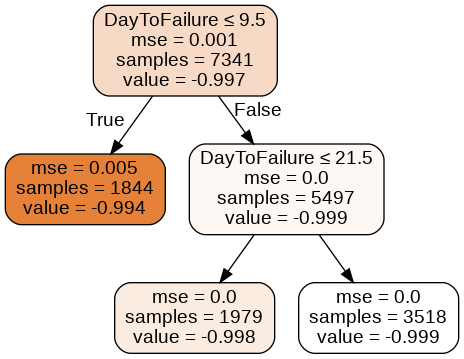

In [15]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names =datafortree.columns,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())